In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.cm as cm
import random
from scipy.stats import stats
from sklearn.cluster import SpectralClustering

In [2]:
#load data
stocks = pd.read_csv("all_stocks_5yr.csv")

In [3]:
stocks.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

In [4]:
#drop unnessecary columns

In [5]:
stocks = stocks.drop(columns=['high', 'low', 'volume'])

In [6]:
stocks.columns

Index(['date', 'open', 'close', 'Name'], dtype='object')

In [7]:
#add percent return column
stocks['percent_return'] = (stocks['close'] - stocks['open']) / stocks['open']

In [8]:
stocks.head()

,date,open,close,Name,percent_return
0,2013-02-08,15.07,14.75,AAL,-0.021234
1,2013-02-11,14.89,14.46,AAL,-0.028878
2,2013-02-12,14.45,14.27,AAL,-0.012457
3,2013-02-13,14.30,14.66,AAL,0.025175
4,2013-02-14,14.94,13.99,AAL,-0.063588


In [9]:
def check_correlation(correlation):
    if correlation != "":
        correlation = float(correlation)
        if np.isfinite(correlation) and not np.isnan(correlation):
            return correlation
    return 0

In [10]:
#finds the correlation between percent_return of stock [name1] and stock [name2] [offset] days later
def correlation(name1, name2, offset, stocks_pivot):
    correlation = stocks_pivot[name1].corr(stocks_pivot[name2])
    return correlation

In [11]:
#finds the correlation between percent_return of stock [name1] and stock [name2] [offset] days later
def correlation_offset(name1, name2, offset):
    if offset < 0: return 'Offset must be non-negative'
    stocks_filtered = stocks.loc[(stocks['Name'] == name1) | (stocks['Name'] == name2)]
    stocks_pivot = stocks_filtered.pivot(index='date', columns='Name', values='percent_return')
    stocks_pivot[name2] = stocks_pivot[name2].shift(-offset)
    correlation = stocks_pivot[name1].corr(stocks_pivot[name2])
    return correlation

In [12]:
#sample calls to correlation function
print(correlation_offset('NVDA', 'AMD', 0))
print(correlation_offset('NVDA', 'AMD', 1))
print(correlation_offset('NVDA', 'AMD', 7))
print(correlation_offset('NVDA', 'AMD', 30))

0.3903250393024427
0.030439793761227307
-0.0127650700466408
-0.03597015357728092


In [13]:
#list of distinct stocks
unique = stocks['Name'].unique()
print(unique[:10])

['AAL' 'AAPL' 'AAP' 'ABBV' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADI' 'ADM']


In [14]:
def populate_edges(unique, offset=1):
    if offset < 0: return 'Offset must be non-negative'
    stocks_pivot = stocks.pivot(index='date', columns='Name', values='percent_return')
    edges = np.zeros((len(unique),len(unique)))
    for i, stock2 in enumerate(unique):
        stocks_pivot[stock2] = stocks_pivot[stock2].shift(-offset)
        for j, stock1 in enumerate(unique):
            if edges[j, i] != 0: continue
            corr = correlation(stock1, stock2, offset, stocks_pivot)
            edges[j, i] = corr
        stocks_pivot[stock2] = stocks_pivot[stock2].shift(offset)
    return edges

In [15]:
#create adjacency matrices with naming convention weights{offset in days}
weights0 = populate_edges(unique, 0)
weights1 = populate_edges(unique, 1)
weights7 = populate_edges(unique, 7)
weights30 = populate_edges(unique, 30)

In [16]:
print(weights0.shape)
print(weights1.shape)
print(weights7.shape)
print(weights30.shape)

(505, 505)
(505, 505)
(505, 505)
(505, 505)


In [17]:
#initialize graphs corresponding to each adjacency matrix of weights
G0 = nx.DiGraph()
G1 = nx.DiGraph()
G7 = nx.DiGraph()
G30 = nx.DiGraph()

In [18]:
def add_nodes(graph):
    graph.add_nodes_from([(i, {"name" : stock, "residue" : 0}) for i, stock in enumerate(unique)])

In [19]:
def add_edges(graph, edges):
    rows, cols = edges.shape
    for row in range(rows):
        for col in range(cols):
            if row != col: graph.add_edge(row, col, weight=edges[row, col])

In [20]:
def make_graph(graph, edges):
    add_nodes(graph)
    add_edges(graph, edges)

In [21]:
make_graph(G0, weights0)
make_graph(G1, weights1)
make_graph(G7, weights7)
make_graph(G30, weights30)

In [22]:
print(G0.number_of_edges())
print(G0.number_of_nodes())
print(G0.out_degree(0))

254520
505
504


In [23]:
#plots the {tag}-degree distribution such that tag is one of ['in', 'out']
def plot_degree_dist(graph, tag, offset):
    if tag not in ['in', 'out']: return 'invalid tag'
    if tag == 'in': degrees = dict(graph.in_degree(weight='weight'))
    else: degrees = dict(graph.out_degree(weight='weight'))
    nodes = graph.nodes()
    degrees_values = [degrees[node] for node in nodes]
    num_bins = 10
    hist, bin_edges = np.histogram(degrees_values, bins=num_bins)
    plt.figure(figsize=(10, 5))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge')
    plt.xlabel(f'Weighted {tag}-Degree Range')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of Nodes in Weighted {tag}-Degree in Graph with Offset {offset}')
    plt.xticks(bin_edges)
    plt.show()

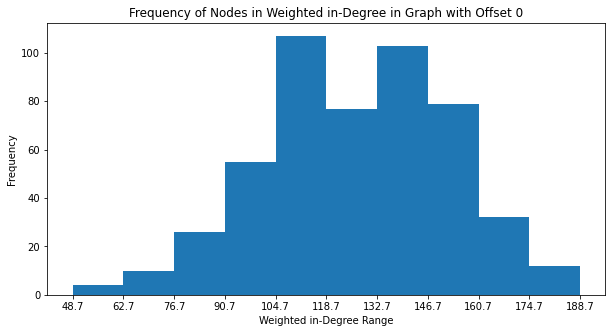

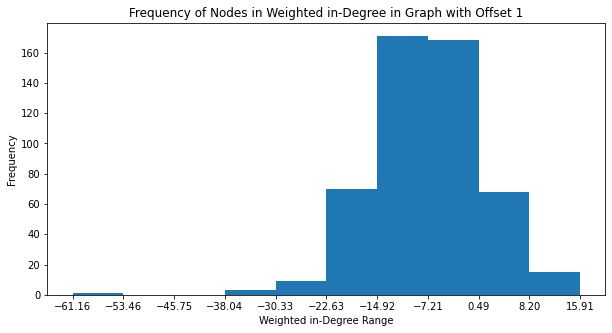

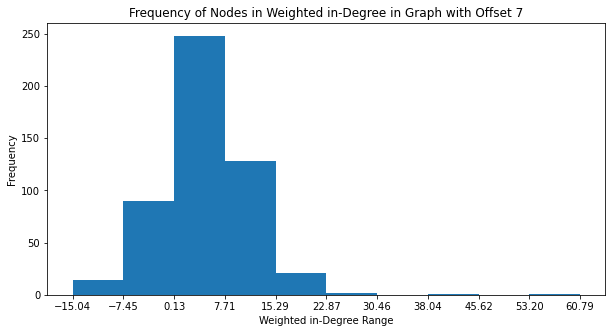

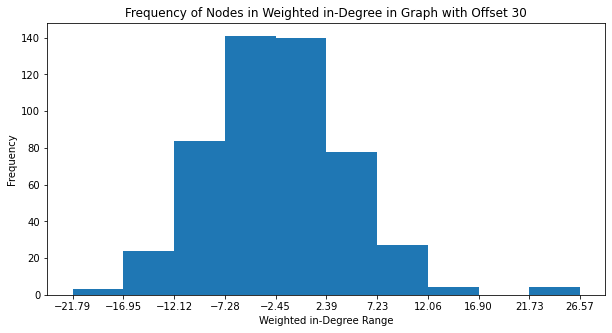

In [24]:
plot_degree_dist(G0, 'in', 0)
plot_degree_dist(G1, 'in', 1)
plot_degree_dist(G7, 'in', 7)
plot_degree_dist(G30, 'in', 30)

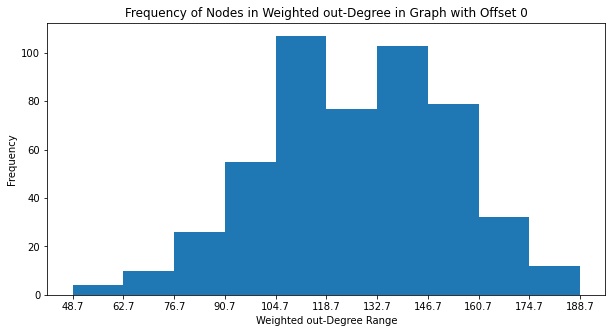

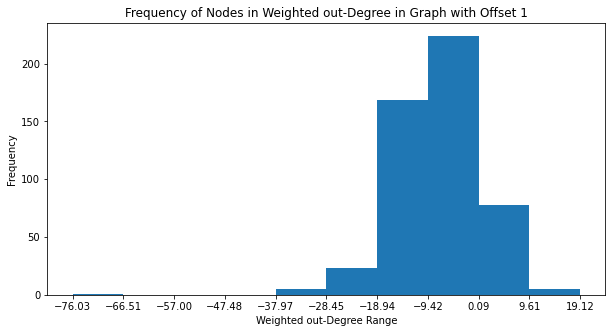

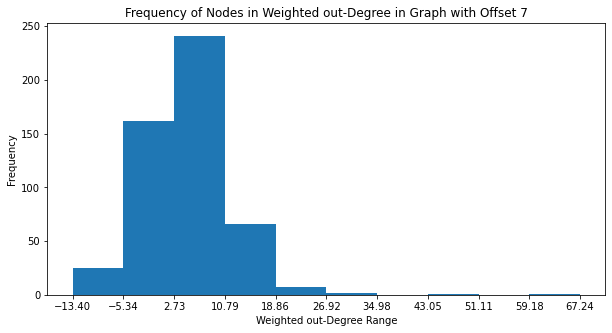

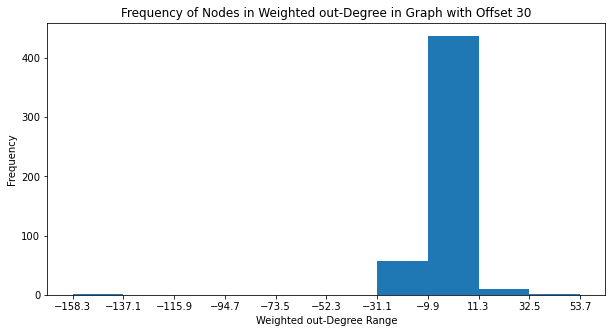

In [25]:
plot_degree_dist(G0, 'out', 0)
plot_degree_dist(G1, 'out', 1)
plot_degree_dist(G7, 'out', 7)
plot_degree_dist(G30, 'out', 30)

In [26]:
#compute the min and max spanning trees
'''min_st0 = nx.minimum_spanning_arborescence(G0)
min_st1 = nx.minimum_spanning_arborescence(G1)
min_st7 = nx.minimum_spanning_arborescence(G7)
min_st30 = nx.minimum_spanning_arborescence(G30)
max_st0 = nx.maximum_spanning_arborescence(G0)
max_st1 = nx.maximum_spanning_arborescence(G1)
max_st7 = nx.maximum_spanning_arborescence(G7)
max_st30 = nx.maximum_spanning_arborescence(G30)'''

'min_st0 = nx.minimum_spanning_arborescence(G0)\nmin_st1 = nx.minimum_spanning_arborescence(G1)\nmin_st7 = nx.minimum_spanning_arborescence(G7)\nmin_st30 = nx.minimum_spanning_arborescence(G30)\nmax_st0 = nx.maximum_spanning_arborescence(G0)\nmax_st1 = nx.maximum_spanning_arborescence(G1)\nmax_st7 = nx.maximum_spanning_arborescence(G7)\nmax_st30 = nx.maximum_spanning_arborescence(G30)'

In [27]:
def get_degree_extrema(graph, tag, in_out_tag):
    if tag not in ['max', 'min'] or in_out_tag not in ['in', 'out']:
        return 'invalid tag or in_out_tag'

    node_degrees = {}
    for node in graph.nodes:
        if in_out_tag == 'in':
            degree = sum(data.get('weight', 0) for _, _, data in graph.in_edges(node, data=True))
        else:
            degree = sum(data.get('weight', 0) for _, _, data in graph.out_edges(node, data=True))
        node_degrees[node] = degree

    if tag == 'max':
        node_with_extrema = max(node_degrees, key=node_degrees.get)
    else:
        node_with_extrema = min(node_degrees, key=node_degrees.get)
    return graph.nodes[node_with_extrema]['name']

In [28]:
print(f'max in degree in G0 is: {get_degree_extrema(G0, "max", "in")}')
print(f'max in degree in G1 is: {get_degree_extrema(G1, "max", "in")}')
print(f'max in degree in G7 is: {get_degree_extrema(G7, "max", "in")}')
print(f'max in degree in G30 is: {get_degree_extrema(G30, "max", "in")}')
print(f'min in degree in G0 is: {get_degree_extrema(G0, "min", "in")}')
print(f'min in degree in G1 is: {get_degree_extrema(G1, "min", "in")}')
print(f'min in degree in G7 is: {get_degree_extrema(G7, "min", "in")}')
print(f'min in degree in G30 is: {get_degree_extrema(G30, "min", "in")}')

max in degree in G0 is: HON
max in degree in G1 is: NAVI
max in degree in G7 is: APTV
max in degree in G30 is: APTV
min in degree in G0 is: CHD
min in degree in G1 is: DWDP
min in degree in G7 is: ABBV
min in degree in G30 is: CHD


In [29]:
print(f'max out degree out G0 is: {get_degree_extrema(G0, "max", "out")}')
print(f'max out degree out G1 is: {get_degree_extrema(G1, "max", "out")}')
print(f'max out degree out G7 is: {get_degree_extrema(G7, "max", "out")}')
print(f'max out degree out G30 is: {get_degree_extrema(G30, "max", "out")}')
print(f'min out degree out G0 is: {get_degree_extrema(G0, "min", "out")}')
print(f'min out degree out G1 is: {get_degree_extrema(G1, "min", "out")}')
print(f'min out degree out G7 is: {get_degree_extrema(G7, "min", "out")}')
print(f'min out degree out G30 is: {get_degree_extrema(G30, "min", "out")}')

max out degree out G0 is: HON
max out degree out G1 is: INCY
max out degree out G7 is: APTV
max out degree out G30 is: BHF
min out degree out G0 is: CHD
min out degree out G1 is: APTV
min out degree out G7 is: SYY
min out degree out G30 is: APTV


In [30]:
def split_directed_graph(graph):
    graph1 = nx.Graph()
    graph2 = nx.Graph()

    for u, v, data in graph.edges(data=True):
        weight = data.get('weight', 1)  # Default weight is 1 if not specified
        graph1.add_edge(u, v, weight=weight)
        graph2.add_edge(v, u, weight=weight)

    return graph1, graph2

In [31]:
G0_split1, G0_split2 = split_directed_graph(G0)
G1_split1, G1_split2 = split_directed_graph(G1)
G7_split1, G7_split2 = split_directed_graph(G7)
G30_split1, G30_split2 = split_directed_graph(G30)

In [32]:
# Use the Louvain community detection algorithm to partition the graph into connecrted communities (doesn't work for asymetric graph)
def find_communities(graph):
    return nx.community.louvain_communities(graph, seed=123)

In [33]:
G0_split1_community = find_communities(G0_split1)
G0_split2_community = find_communities(G0_split2)
G1_split1_community = find_communities(G1_split1)
G1_split2_community = find_communities(G1_split2)
G7_split1_community = find_communities(G7_split1)
G7_split2_community = find_communities(G7_split2)
G30_split1_community = find_communities(G30_split1)
G30_split2_community = find_communities(G30_split2)

In [34]:
#filter communites to only include multi-node communities (remove communities of single stock)
def filter_communities(community):
    return [c for c in community if len(c) > 1]

In [35]:
G0_split1_community = filter_communities(G0_split1_community)
G0_split2_community = filter_communities(G0_split2_community)
G1_split1_community = filter_communities(G1_split1_community)
G1_split2_community = filter_communities(G1_split2_community)
G7_split1_community = filter_communities(G7_split1_community)
G7_split2_community = filter_communities(G7_split2_community)
G30_split1_community = filter_communities(G30_split1_community)
G30_split2_community = filter_communities(G30_split2_community)

In [36]:
print(len(G0_split1_community))
print(len(G0_split2_community))
print(len(G1_split1_community))
print(len(G1_split2_community))
print(len(G7_split1_community))
print(len(G7_split2_community))
print(len(G30_split1_community))
print(len(G30_split2_community))

4
4
3
3
4
4
2
2


In [37]:
def get_community_names(communities, graph):
    res = list()
    for community in communities:
        add = list()
        for stock in community:
            add.append(graph.nodes[stock]['name'])
        res.append(add)
    return res

In [38]:
community_names0_split1 = get_community_names(G0_split1_community, G0)
community_names0_split2 = get_community_names(G0_split2_community, G0)
community_names1_split1 = get_community_names(G1_split1_community, G1)
community_names1_split2 = get_community_names(G1_split2_community, G1)
community_names7_split1 = get_community_names(G7_split1_community, G7)
community_names7_split2 = get_community_names(G7_split2_community, G7)
community_names30_split1 = get_community_names(G30_split1_community, G30)
community_names30_split2 = get_community_names(G30_split2_community, G30)

In [39]:
print(community_names0_split1)

[['AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADSK', 'ADS', 'AET', 'AGN', 'AKAM', 'ALGN', 'ALLE', 'ALXN', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'ANTM', 'APH', 'APTV', 'ATVI', 'AVGO', 'AVY', 'A', 'BAX', 'BDX', 'BIIB', 'BMY', 'BSX', 'CAH', 'CA', 'CCL', 'CDNS', 'CELG', 'CERN', 'CI', 'CNC', 'COO', 'CRM', 'CSCO', 'CTSH', 'CTXS', 'DGX', 'DHR', 'DISH', 'DVA', 'DXC', 'EA', 'EBAY', 'EFX', 'ESRX', 'EVHC', 'EW', 'EXPE', 'FB', 'FFIV', 'FISV', 'FIS', 'GILD', 'GOOGL', 'GOOG', 'GPN', 'HCA', 'HOLX', 'HPQ', 'HRS', 'HSIC', 'HUM', 'IDXX', 'ILMN', 'INCY', 'INFO', 'INTC', 'INTU', 'IQV', 'ISRG', 'IT', 'JNPR', 'KLAC', 'LH', 'LLY', 'LRCX', 'MA', 'MCHP', 'MCK', 'MCO', 'MDT', 'MGM', 'MRK', 'MSFT', 'MSI', 'MTD', 'MU', 'MYL', 'NCLH', 'NFLX', 'NVDA', 'NWL', 'ORCL', 'PCLN', 'PDCO', 'PFE', 'PKI', 'PRGO', 'PYPL', 'QCOM', 'QRVO', 'RCL', 'REGN', 'RHT', 'RMD', 'SNPS', 'SPGI', 'SWKS', 'SYK', 'SYMC', 'TDG', 'TEL', 'TMO', 'TRIP', 'TSS', 'TXN', 'UHS', 'UNH', 'VAR', 'VRSK', 'VRSN', 'VRTX', 'V', 'WAT', 'WBA', 'WDC',

In [40]:
print(community_names0_split2)

[['AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADSK', 'ADS', 'AET', 'AGN', 'AKAM', 'ALGN', 'ALLE', 'ALXN', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'ANTM', 'APH', 'APTV', 'ATVI', 'AVGO', 'AVY', 'A', 'BAX', 'BDX', 'BIIB', 'BMY', 'BSX', 'CAH', 'CA', 'CCL', 'CDNS', 'CELG', 'CERN', 'CI', 'CNC', 'COO', 'CRM', 'CSCO', 'CTSH', 'CTXS', 'DGX', 'DHR', 'DISH', 'DVA', 'DXC', 'EA', 'EBAY', 'EFX', 'ESRX', 'EVHC', 'EW', 'EXPE', 'FB', 'FFIV', 'FISV', 'FIS', 'GILD', 'GOOGL', 'GOOG', 'GPN', 'HCA', 'HOLX', 'HPQ', 'HRS', 'HSIC', 'HUM', 'IDXX', 'ILMN', 'INCY', 'INFO', 'INTC', 'INTU', 'IQV', 'ISRG', 'IT', 'JNPR', 'KLAC', 'LH', 'LLY', 'LRCX', 'MA', 'MCHP', 'MCK', 'MCO', 'MDT', 'MGM', 'MRK', 'MSFT', 'MSI', 'MTD', 'MU', 'MYL', 'NCLH', 'NFLX', 'NVDA', 'NWL', 'ORCL', 'PCLN', 'PDCO', 'PFE', 'PKI', 'PRGO', 'PYPL', 'QCOM', 'QRVO', 'RCL', 'REGN', 'RHT', 'RMD', 'SNPS', 'SPGI', 'SWKS', 'SYK', 'SYMC', 'TDG', 'TEL', 'TMO', 'TRIP', 'TSS', 'TXN', 'UHS', 'UNH', 'VAR', 'VRSK', 'VRSN', 'VRTX', 'V', 'WAT', 'WBA', 'WDC',

In [41]:
print(community_names1_split1)

[['AAPL', 'ABBV', 'ACN', 'ADBE', 'ADI', 'ADP', 'AEE', 'AEP', 'AES', 'AET', 'AFL', 'AGN', 'AIV', 'AIZ', 'AKAM', 'ALK', 'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AMGN', 'AMT', 'AMZN', 'ANDV', 'ANSS', 'AON', 'AOS', 'APTV', 'ARE', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AZO', 'A', 'BBY', 'BDX', 'BF.B', 'BIIB', 'BLL', 'BMY', 'BRK.B', 'BSX', 'BXP', 'CAG', 'CBOE', 'CB', 'CCI', 'CDNS', 'CELG', 'CERN', 'CHD', 'CINF', 'CLX', 'CL', 'CMS', 'COG', 'COO', 'CPB', 'CRM', 'CSCO', 'CTAS', 'CTSH', 'CVS', 'CVX', 'DE', 'DG', 'DHR', 'DIS', 'DLR', 'DPS', 'DRE', 'DTE', 'DUK', 'DWDP', 'DXC', 'D', 'EA', 'EBAY', 'ED', 'EIX', 'EL', 'EQIX', 'EQR', 'EQT', 'ESS', 'ES', 'ETR', 'EW', 'EXC', 'EXPE', 'EXR', 'FB', 'FE', 'FISV', 'FIS', 'FOXA', 'FOX', 'FRT', 'FTI', 'FTV', 'GILD', 'GIS', 'GOOGL', 'GOOG', 'GPN', 'HCN', 'HCP', 'HOLX', 'HON', 'HPE', 'HRL', 'HSIC', 'HSY', 'ICE', 'IDXX', 'IFF', 'ILMN', 'INFO', 'INTC', 'IQV', 'ISRG', 'IT', 'JNJ', 'KHC', 'KIM', 'KLAC', 'KMB', 'KO', 'KR', 'K', 'LEG', 'LLL', 'LLY', 'LMT', 'LNT', 'LRCX', 

In [42]:
print(community_names1_split2)

[['AAPL', 'ABBV', 'ACN', 'ADBE', 'ADI', 'ADP', 'AEE', 'AEP', 'AES', 'AFL', 'AGN', 'AIV', 'AIZ', 'AKAM', 'ALK', 'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AMGN', 'AMT', 'AMZN', 'ANDV', 'ANSS', 'AON', 'AOS', 'APTV', 'ARE', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AZO', 'A', 'BBY', 'BDX', 'BF.B', 'BIIB', 'BLL', 'BMY', 'BRK.B', 'BSX', 'BXP', 'CAG', 'CBOE', 'CB', 'CCI', 'CDNS', 'CELG', 'CERN', 'CHD', 'CINF', 'CLX', 'CL', 'CMS', 'COG', 'COO', 'CPB', 'CRM', 'CSCO', 'CTAS', 'CTSH', 'CVS', 'CVX', 'DE', 'DG', 'DHR', 'DIS', 'DLR', 'DPS', 'DRE', 'DTE', 'DUK', 'DWDP', 'DXC', 'D', 'EA', 'EBAY', 'ED', 'EIX', 'EL', 'EQIX', 'EQR', 'EQT', 'ESS', 'ES', 'ETR', 'EW', 'EXC', 'EXPE', 'EXR', 'FB', 'FE', 'FISV', 'FIS', 'FOXA', 'FOX', 'FRT', 'FTI', 'FTV', 'GILD', 'GIS', 'GOOGL', 'GOOG', 'GPN', 'HCN', 'HCP', 'HOLX', 'HON', 'HPE', 'HRL', 'HSIC', 'HSY', 'ICE', 'IDXX', 'IFF', 'ILMN', 'INFO', 'IPG', 'IQV', 'ISRG', 'IT', 'JNJ', 'KHC', 'KIM', 'KLAC', 'KMB', 'KO', 'KR', 'K', 'LEG', 'LLL', 'LLY', 'LMT', 'LNT', 'LRCX', 'LUV', '

In [43]:
print(community_names7_split1)

[['KORS', 'KSS', 'LRCX', 'MAA', 'MAT', 'MCD', 'MCHP', 'APTV', 'MOS', 'NEM', 'NOV', 'NUE', 'NVDA', 'ORCL', 'COG', 'PH', 'CXO', 'RRC', 'DWDP', 'EA', 'SLB', 'SNA', 'SNI', 'ESRX', 'ESS', 'SWKS', 'EXR', 'GILD', 'XOM', 'INTC'], ['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'ADS', 'AES', 'AET', 'AFL', 'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALGN', 'ALK', 'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP', 'AMZN', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC', 'APD', 'APH', 'ARE', 'ARNC', 'AVGO', 'AVY', 'AXP', 'AYI', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BK', 'BLK', 'BLL', 'BRK.B', 'BWA', 'BXP', 'CAG', 'CAH', 'CA', 'CBG', 'CBOE', 'CCL', 'CDNS', 'CELG', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'COL', 'COO', 'COST', 'CRM', 'CSCO', 'CSX', 'CTSH', 'CTXS', 'CVS', 'DAL', 'DE', 'DFS', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DISH', 'DIS', 'DRE', 'DRI', 'DXC', 'EBAY', 'EMN', 'EMR'

In [44]:
print(community_names7_split2)

[['KORS', 'KSS', 'LRCX', 'MCD', 'MCHP', 'APTV', 'MOS', 'NEM', 'NOV', 'NUE', 'NVDA', 'ORCL', 'COG', 'PH', 'CXO', 'RL', 'RRC', 'DWDP', 'EA', 'SLB', 'SNA', 'SNI', 'ESS', 'SWKS', 'TXN', 'UAA', 'GILD', 'XOM', 'INTC'], ['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'ADS', 'AES', 'AET', 'AFL', 'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALGN', 'ALK', 'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP', 'AMZN', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC', 'APD', 'APH', 'ARE', 'ARNC', 'AVGO', 'AVY', 'AXP', 'AYI', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BK', 'BLK', 'BLL', 'BRK.B', 'BWA', 'BXP', 'CAH', 'CAG', 'CA', 'CBG', 'CBOE', 'CCL', 'CDNS', 'CELG', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'COL', 'COO', 'COST', 'CRM', 'CSCO', 'CSX', 'CTL', 'CTSH', 'CTXS', 'CVS', 'DAL', 'DE', 'DFS', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DISH', 'DIS', 'DRE', 'DRI', 'DXC', 'EBAY', 'EMN', 'EMR', 

In [45]:
print(community_names30_split1)

[['AAL', 'ACN', 'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'ALLE', 'AMG', 'AMP', 'ANDV', 'ANSS', 'ANTM', 'APA', 'APC', 'APH', 'APTV', 'AVB', 'AWK', 'BAC', 'BBT', 'BEN', 'BHF', 'BHGE', 'BIIB', 'BMY', 'BRK.B', 'BWA', 'BXP', 'CAG', 'CAT', 'CA', 'CBOE', 'CB', 'CDNS', 'CFG', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CMA', 'CMCSA', 'CME', 'CMI', 'CMS', 'COF', 'COG', 'COO', 'COP', 'COST', 'COTY', 'CSCO', 'CSRA', 'CSX', 'CTL', 'CTSH', 'CTXS', 'CVX', 'DE', 'DFS', 'DGX', 'DHR', 'DISCA', 'DISCK', 'DISH', 'DIS', 'DRE', 'DTE', 'DUK', 'DVA', 'DVN', 'DWDP', 'D', 'EA', 'EBAY', 'ED', 'EIX', 'EL', 'EOG', 'EQR', 'EQT', 'ESRX', 'ESS', 'ES', 'ETFC', 'ETN', 'ETR', 'EVHC', 'EXC', 'EXPE', 'FE', 'FITB', 'FLIR', 'FLR', 'FLS', 'FOXA', 'FTV', 'F', 'GLW', 'GM', 'GPN', 'GPS', 'GS', 'HBAN', 'HBI', 'HCP', 'HES', 'HLT', 'HPE', 'HPQ', 'HP', 'HST', 'IBM', 'ICE', 'ILMN', 'INTU', 'ISRG', 'ITW', 'IVZ', 'JBHT', 'JCI', 'JNJ', 'JNPR', 'JPM', 'JWN', 'KEY', 'KHC', 'KMI', 'KSS', 'LH', 'LKQ', 'LLY',

In [46]:
print(community_names30_split2)

[['AAL', 'ACN', 'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'ALLE', 'AMG', 'AMP', 'ANDV', 'ANSS', 'ANTM', 'APA', 'APC', 'APH', 'APTV', 'AVB', 'AWK', 'BAC', 'BBT', 'BEN', 'BHF', 'BHGE', 'BIIB', 'BMY', 'BRK.B', 'BWA', 'BXP', 'CAG', 'CAT', 'CA', 'CBOE', 'CB', 'CDNS', 'CFG', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CMA', 'CMCSA', 'CME', 'CMI', 'CMS', 'COF', 'COG', 'COO', 'COP', 'COST', 'COTY', 'CSCO', 'CSRA', 'CSX', 'CTL', 'CTSH', 'CTXS', 'CVX', 'DE', 'DFS', 'DGX', 'DHR', 'DISCA', 'DISCK', 'DISH', 'DIS', 'DRE', 'DTE', 'DUK', 'DVA', 'DVN', 'DWDP', 'D', 'EA', 'EBAY', 'ED', 'EIX', 'EL', 'EOG', 'EQR', 'EQT', 'ESRX', 'ESS', 'ES', 'ETFC', 'ETN', 'ETR', 'EVHC', 'EXC', 'EXPE', 'FE', 'FITB', 'FLIR', 'FLR', 'FLS', 'FOXA', 'FTV', 'F', 'GLW', 'GM', 'GPN', 'GPS', 'GS', 'HBAN', 'HBI', 'HCP', 'HES', 'HLT', 'HPE', 'HPQ', 'HP', 'HST', 'IBM', 'ICE', 'ILMN', 'INTU', 'ISRG', 'ITW', 'IVZ', 'JBHT', 'JCI', 'JNJ', 'JNPR', 'JPM', 'JWN', 'KEY', 'KHC', 'KMI', 'KSS', 'LH', 'LKQ', 'LLY',

In [47]:
#data structure to store residue from cascade
residue_accumulation0 = [0 for _ in range(G0.number_of_nodes())]
residue_accumulation1 = [0 for _ in range(G1.number_of_nodes())]
residue_accumulation7 = [0 for _ in range(G7.number_of_nodes())]
residue_accumulation30 = [0 for _ in range(G30.number_of_nodes())]

In [48]:
def information_cascade(graph, start_node, start_value, accumulation):
    # Initialize node values
    node_values = {node: 0 for node in graph.nodes}
    node_values[start_node] = start_value
    
    # Perform cascade until no more residue to spread
    while True:
        any_residue = False
        
        for node in graph.nodes:
            residue = node_values[node]
            node_values[node] = 0
            if residue > 1e-10:
                neighbors = graph.neighbors(node)
                for neighbor in neighbors:
                    edge_weight = graph[node][neighbor]['weight']
                    residue_spread = residue * edge_weight
                    accumulation[neighbor] += residue_spread
                    node_values[neighbor] = residue_spread
                    any_residue = True

                node_values[node] = 0

        if not any_residue:
            break

    return accumulation

In [49]:
test_residue_cascade0 = information_cascade(G0, 0, 10, residue_accumulation0)
test_residue_cascade1 = information_cascade(G1, 0, 10, residue_accumulation1)
test_residue_cascade7 = information_cascade(G7, 0, 10, residue_accumulation7)
test_residue_cascade30 = information_cascade(G30, 0, 10, residue_accumulation30)

In [50]:
def rank_by_residue_metric(accumulation):
    return [e[1] for e in sorted([val, i] for i, val in enumerate(accumulation))]

In [51]:
test_residue_cascade0 = rank_by_residue_metric(test_residue_cascade0)
test_residue_cascade0.remove(0)
edges0 = G0.edges(0, data=True)
test_orignal_correlation0 = [e[1] for e in sorted(edges0, key=lambda edge: edge[2]['weight'])]

test_residue_cascade1 = rank_by_residue_metric(test_residue_cascade1)
test_residue_cascade1.remove(0)
edges1 = G1.edges(0, data=True)
test_orignal_correlation1 = [e[1] for e in sorted(edges1, key=lambda edge: edge[2]['weight'])]

test_residue_cascade7 = rank_by_residue_metric(test_residue_cascade7)
test_residue_cascade7.remove(0)
edges7 = G7.edges(0, data=True)
test_orignal_correlation7 = [e[1] for e in sorted(edges7, key=lambda edge: edge[2]['weight'])]

test_residue_cascade30 = rank_by_residue_metric(test_residue_cascade30)
test_residue_cascade30.remove(0)
edges30 = G30.edges(0, data=True)
test_orignal_correlation30 = [e[1] for e in sorted(edges30, key=lambda edge: edge[2]['weight'])]

In [52]:
correlation0, _ = stats.spearmanr(test_residue_cascade0, test_orignal_correlation0)
print(f'correlation0: {correlation0}')
correlation1, _ = stats.spearmanr(test_residue_cascade1, test_orignal_correlation1)
print(f'correlation1: {correlation1}')
correlation7, _ = stats.spearmanr(test_residue_cascade7, test_orignal_correlation7)
print(f'correlation7: {correlation7}')
correlation30, _ = stats.spearmanr(test_residue_cascade30, test_orignal_correlation30)
print(f'correlation30: {correlation30}')

correlation0: 0.060614999301691036
correlation1: 0.08633376544129848
correlation7: 0.0680770633155335
correlation30: 0.19385713067188573


In [53]:
'''
these results are very interesting, correlation0 and 30 are very small but 1 and 7 
seem to be a happy median with very high correlation. What does this mean? Well first off we would
expect similarity between my metrics rankings and correaltion since the cascade based correlation
should be derived froim these with network strcutre accounted for. I also provided spearman correlation
to show that the metric generate is different from correlation and that the network structure has an 
effect on the metric.
'''

'\nthese results are very interesting, correlation0 and 30 are very small but 1 and 7 \nseem to be a happy median with very high correlation. What does this mean? Well first off we would\nexpect similarity between my metrics rankings and correaltion since the cascade based correlation\nshould be derived froim these with network strcutre accounted for. I also provided spearman correlation\nto show that the metric generate is different from correlation and that the network structure has an \neffect on the metric.\n'

In [54]:
def get_price_change(name, stocks):
    filtered_stocks = stocks[(stocks['Name'] == name)]
    if filtered_stocks['percent_return'].values.size == 0: return 0
    return filtered_stocks['percent_return'].values[0]

In [55]:
'''
before I was just using a cascade starting at one stock but in reality many stocks move in a given day.
I will implement a function to perform an overlayed cascade reflected by all price changes in a given day.
'''
def total_cascade(graph, day):
    filtered_stocks = stocks[(stocks['date'] == day)]
    if filtered_stocks.size == 0: return 'invalid date'
    accumulation = [0 for _ in range(graph.number_of_nodes())]
    for node in range(graph.number_of_nodes()):
        accumulation = information_cascade(graph, node, get_price_change(graph.nodes[node]['name'], filtered_stocks), accumulation)
    return accumulation

In [87]:
complete_cascade0 = total_cascade(G0, '2013-06-07')
complete_cascade1 = total_cascade(G1, '2013-06-07')
complete_cascade7 = total_cascade(G7, '2013-06-07')
complete_cascade30 = total_cascade(G30, '2013-06-07')

In [88]:
def sort_by_in_degree(graph):
    weighted_indegrees = {node: sum(data['weight'] for _, _, data in graph.in_edges(node, data=True)) for node in graph.nodes()}
    return sorted(graph.nodes(), key=lambda x: weighted_indegrees[x], reverse=True)

In [89]:
total_residue_metric0 = rank_by_residue_metric(complete_cascade0)
total_weighted_indegress_metric0 = sort_by_in_degree(G0)

total_residue_metric1 = rank_by_residue_metric(complete_cascade1)
total_weighted_indegress_metric1 = sort_by_in_degree(G1)

total_residue_metric7 = rank_by_residue_metric(complete_cascade7)
total_weighted_indegress_metric7 = sort_by_in_degree(G7)

total_residue_metric30 = rank_by_residue_metric(complete_cascade30)
total_weighted_indegress_metric30 = sort_by_in_degree(G30)

In [91]:
correlation0, _ = stats.spearmanr(total_residue_metric0, total_weighted_indegress_metric0)
print(f'correlation0: {correlation0}')

correlation1, _ = stats.spearmanr(total_residue_metric1, total_weighted_indegress_metric1)
print(f'correlation1: {correlation1}')

correlation7, _ = stats.spearmanr(total_residue_metric7, total_weighted_indegress_metric7)
print(f'correlation7: {correlation7}')

correlation30, _ = stats.spearmanr(total_residue_metric30, total_weighted_indegress_metric30)
print(f'correlation30: {correlation30}')

correlation0: 0.061764810021374815
correlation1: -0.05124242237888386
correlation7: -0.0036507688035884345
correlation30: 0.04265066258178614


In [60]:
def name_to_node(G, name):
    for node, data in G.nodes(data=True):
        if 'name' in data and data['name'] == name:
            return node
    return None

In [114]:
#returns the list of stocks in sorted dessceding order to percent return n trading days after date
def get_top_tickers_by_return(df, date, n):
    df['date'] = pd.to_datetime(df['date'])  # Convert 'date' column to Timestamp
    target_date = pd.to_datetime(date)
    target_date_plus_n = target_date + pd.DateOffset(days=n)
    filtered_df = df[(df['date'] >= target_date) & (df['date'] <= target_date_plus_n)]
    grouped_df = filtered_df.groupby('Name')['percent_return'].sum().reset_index()
    ranked_df = grouped_df.sort_values('percent_return', ascending=False)
    ranked_tickers = ranked_df['Name'].tolist()
    return [name_to_node(G0, name) for name in ranked_tickers]

In [115]:
#use spearman correlation to compare residue metric rankings to actual rankings
def final_compare(date, n, df, graph):
    res_rank = rank_by_residue_metric(total_cascade(graph, date))
    act_rank = get_top_tickers_by_return(df, date, n)
    res_rank = [a for a in res_rank if a in act_rank]
    correlation0, _ = stats.spearmanr(res_rank, act_rank)
    return correlation0

In [159]:
def plot_correlation(date, stocks, graph, graph_num):
    correlations = list()
    for offset in range(0,30,3):
        try: correlations.append(final_compare(date, offset, stocks, graph))
        except: return 'invalid date'
    
    plt.plot([i for i in range(0,30,3)], correlations)
    plt.xlabel('Offset Parameter')
    plt.ylabel('Correlation')
    plt.title(f'Correlation vs. Offset (with correlation offset={graph_num} and date={date})')
    plt.axvline(x=graph_num, color='red', linestyle='--')
    plt.show()

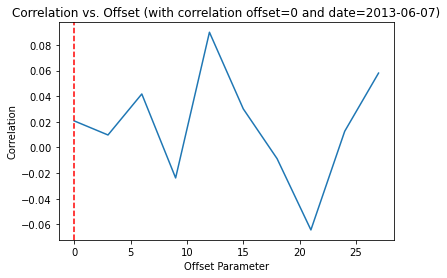

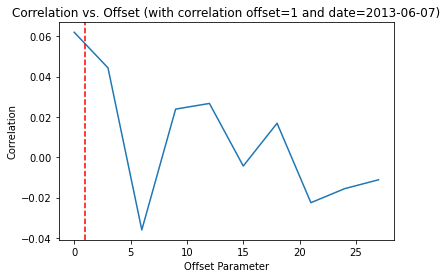

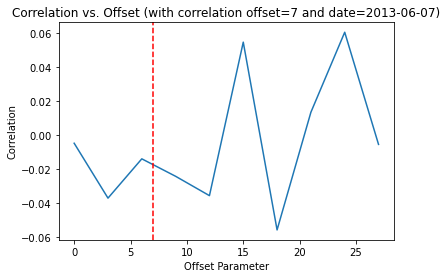

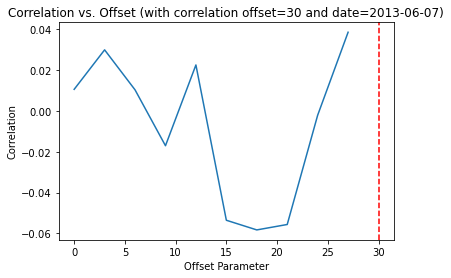

In [160]:
plot_correlation('2013-06-07', stocks, G0, 0)
plot_correlation('2013-06-07', stocks, G1, 1)
plot_correlation('2013-06-07', stocks, G7, 7)
plot_correlation('2013-06-07', stocks, G30,30)

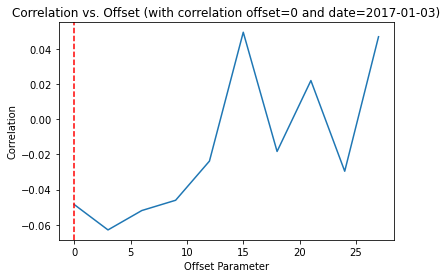

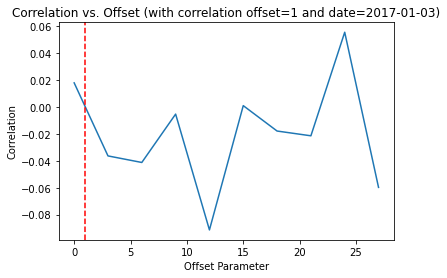

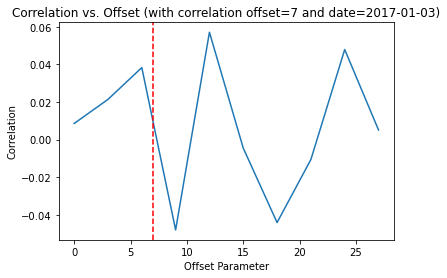

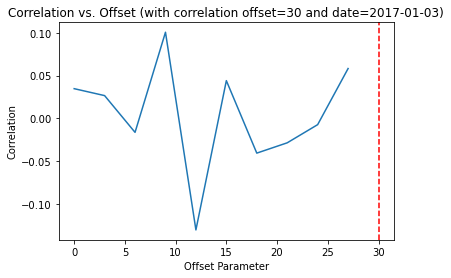

In [161]:
plot_correlation('2017-01-03', stocks, G0, 0)
plot_correlation('2017-01-03', stocks, G1, 1)
plot_correlation('2017-01-03', stocks, G7, 7)
plot_correlation('2017-01-03', stocks, G30,30)